<a href="https://colab.research.google.com/github/SardarAmmer/DataScience-Projects-/blob/main/DEN_Final_Task_(_SpaceX_Analysis)_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Project folders created at: /content/spacex_project


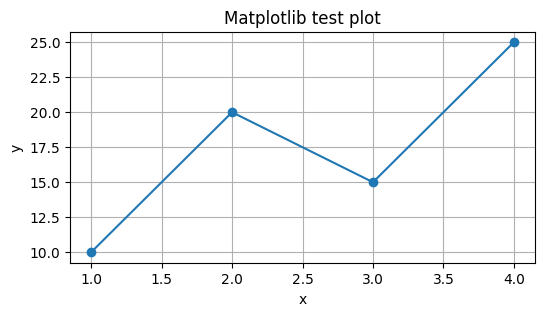


✅ Environment setup complete.


In [2]:
# @title Final Project SpaceX Analysis
# Step 0: Environment setup for SpaceX capstone (Colab)


# 1) Installing packages
!pip install -q folium plotly jupyter-dash pandasql lxml html5lib dash

# 2) Notebook display configuration
%matplotlib inline

import os, random, sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display, HTML

# 3) Reproducibility
RANDOM_SEED = 42
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)
os.environ['PYTHONHASHSEED'] = str(RANDOM_SEED)

# 4) Creating project folders
BASE = '/content/spacex_project'
DATA_RAW = os.path.join(BASE, 'data_raw')
DATA_CLEAN = os.path.join(BASE, 'data_clean')
FIGS = os.path.join(BASE, 'figs')
MODELS = os.path.join(BASE, 'models')

for d in (BASE, DATA_RAW, DATA_CLEAN, FIGS, MODELS):
    os.makedirs(d, exist_ok=True)

print("Project folders created at:", BASE)

# 5) Plotly and Folium setup for inline display
import plotly
import plotly.express as px
import plotly.offline as pyo
pyo.init_notebook_mode(connected=True)

try:
    plotly.io.renderers.default = 'colab'
except Exception:
    pass

import folium
from jupyter_dash import JupyterDash

#Testing Libraries visuals

# Matplotlib test
plt.figure(figsize=(6,3))
plt.plot([1,2,3,4], [10,20,15,25], marker='o')
plt.title('Matplotlib test plot')
plt.xlabel('x')
plt.ylabel('y')
plt.grid(True)
plt.show()

# Plotly test
df_test = pd.DataFrame({'category': ['A','B','C','D'], 'value':[10,15,7,12]})
fig = px.bar(df_test, x='category', y='value', title='Plotly test bar chart')
fig.show()

# Folium test map (Kennedy Space Center coords) - should render inline
m = folium.Map(location=[28.572872, -80.648980], zoom_start=5)
folium.Marker([28.572872, -80.648980], popup='Kennedy Space Center (test)').add_to(m)

# Display map inline
display(m)

# 7) Summary
print("\n✅ Environment setup complete.")




In [3]:
# @title Data Collection Using SpaceX API

# Collect data from SpaceX REST API

import requests
import pandas as pd
import plotly.express as px

# --- Helper function ---
def fetch_data(url):
    r = requests.get(url)
    r.raise_for_status()
    return r.json()

# --- API Endpoints ---
urls = {
    "launches": "https://api.spacexdata.com/v4/launches",
    "rockets": "https://api.spacexdata.com/v4/rockets",
    "payloads": "https://api.spacexdata.com/v4/payloads",
    "cores": "https://api.spacexdata.com/v4/cores",
    "launchpads": "https://api.spacexdata.com/v4/launchpads",
    "landpads": "https://api.spacexdata.com/v4/landpads"
}

# --- Fetch & Normalize ---
df_launches = pd.json_normalize(fetch_data(urls["launches"]))
df_rockets = pd.json_normalize(fetch_data(urls["rockets"]))
df_payloads = pd.json_normalize(fetch_data(urls["payloads"]))
df_cores = pd.json_normalize(fetch_data(urls["cores"]))
df_launchpads = pd.json_normalize(fetch_data(urls["launchpads"]))
df_landpads = pd.json_normalize(fetch_data(urls["landpads"]))

print("✅ Data successfully collected from SpaceX API")
print("Launches:", df_launches.shape, "Rockets:", df_rockets.shape, "Payloads:", df_payloads.shape)

# --- Quick Preview ---
display(df_launches[["name","date_utc","rocket","payloads","cores"]].head(5))

# --- Graphical Overview: launches per year ---
df_launches['year'] = pd.to_datetime(df_launches['date_utc']).dt.year
launches_per_year = df_launches['year'].value_counts().sort_index()

fig = px.line(
    x=launches_per_year.index,
    y=launches_per_year.values,
    markers=True,
    labels={'x':'Year','y':'Number of Launches'},
    title="Number of SpaceX Launches Per Year (API Data)"
)
fig.show()


✅ Data successfully collected from SpaceX API
Launches: (205, 43) Rockets: (4, 56) Payloads: (225, 34)


,name,date_utc,rocket,payloads,cores
0,FalconSat,2006-03-24T22:30:00.000Z,5e9d0d95eda69955f709d1eb,[5eb0e4b5b6c3bb0006eeb1e1],"[{'core': '5e9e289df35918033d3b2623', 'flight'..."
1,DemoSat,2007-03-21T01:10:00.000Z,5e9d0d95eda69955f709d1eb,[5eb0e4b6b6c3bb0006eeb1e2],"[{'core': '5e9e289ef35918416a3b2624', 'flight'..."
2,Trailblazer,2008-08-03T03:34:00.000Z,5e9d0d95eda69955f709d1eb,"[5eb0e4b6b6c3bb0006eeb1e3, 5eb0e4b6b6c3bb0006e...","[{'core': '5e9e289ef3591814873b2625', 'flight'..."
3,RatSat,2008-09-28T23:15:00.000Z,5e9d0d95eda69955f709d1eb,[5eb0e4b7b6c3bb0006eeb1e5],"[{'core': '5e9e289ef3591855dc3b2626', 'flight'..."
4,RazakSat,2009-07-13T03:35:00.000Z,5e9d0d95eda69955f709d1eb,[5eb0e4b7b6c3bb0006eeb1e6],"[{'core': '5e9e289ef359184f103b2627', 'flight'..."


In [4]:
# @title Data Collection: Now Performing Web Scraping Falcon 9 launches from Wikipedia


import pandas as pd
import matplotlib.pyplot as plt
import requests

# Wikipedia page link
wiki_url = "https://en.wikipedia.org/wiki/List_of_Falcon_9_and_Falcon_Heavy_launches"
import requests
headers = {"User-Agent": "Mozilla/5.0"}
response = requests.get(wiki_url, headers=headers)
tables = pd.read_html(response.text, flavor='bs4')  # ✅ works

print(f"✅ {len(tables)} tables found on the page")

# Typically the first few big tables are launch records
df_wiki = tables[2]   # pick the 3rd table (Falcon 9/Heavy launches)
print("Wiki Table Shape:", df_wiki.shape)

# Preview scraped data
display(df_wiki.head(5))

# --- Graphical Overview: Payload mass distribution (where available)
# Clean payload mass column if exists
if "Payload mass" in df_wiki.columns:
    # Extract numeric part in kg
    df_wiki["PayloadMass_kg"] = (
        df_wiki["Payload mass"]
        .astype(str)
        .str.extract(r"([\d,]+)")
        [0]
        .str.replace(",","")
        .astype(float)
    )
    df_wiki["PayloadMass_kg"].dropna(inplace=True)

    plt.figure(figsize=(8,4))
    df_wiki["PayloadMass_kg"].plot(kind='hist', bins=30, color="skyblue", edgecolor="black")
    plt.title("🚀 Distribution of Payload Mass (Wikipedia Data)")
    plt.xlabel("Payload mass (kg)")
    plt.ylabel("Frequency")
    plt.show()


HTTPError: HTTP Error 403: Forbidden